# Анализ пользовательского поведения в мобильном приложении

## Содержание


<ul>
    <li><a href="#step_1">Введение</a></li>
    <li><a href="#step_2">Изучение общей информации о данных</a></li>
    <li><a href="#step_3">Предобработка данных</a></li>
    <li><a href="#step_4">Изучение и проверка данных</a>
    <ul>
        <li><a href="#step_4_1">Определение количества событий в логе</a></li>
        <li><a href="#step_4_2">Определение количества пользователей в логе</a></li>
        <li><a href="#step_4_3">Определение среднего количества событий на пользователя</a></li>
        <li><a href="#step_4_4">Определение временных границ эксперимента</a></li>
    </ul></li>
    <li><a href="#step_5">Изучение воронки событий</a>
    <ul>
        <li><a href="#step_5_1">Частота встречаемости событий в логах</a></li>
        <li><a href="#step_5_2">Определение количества пользователей совершивших каждое из событий</a></li> 
        <li><a href="#step_5_3">Вид воронки событий</a></li>
        <li><a href="#step_5_4">Расчёт доли пользователей, переходящих на следующий шаг воронки</a></li>
    </ul></li>
    <li><a href="#step_6">Изучение результатов эксперимента</a>
        <ul>
        <li><a href="#step_6_1">Определение количества пользователей в каждой экспериментальной группе</a></li> 
        <li><a href="#step_6_2">Проверка наличия статистической значимости между пользователями групп 246 и 247 (A/A-тест)</a></li> 
        <li><a href="#step_6_3">Анализ результатов A/B-теста</a></li> 
        <li><a href="#step_6_4">Выбор уровня статистической значимости</a></li> 
    </ul></li>
    <li><a href="#step_7">Выводы</a></li>
</ul>

<a id='step_1'></a>
## Введение

**Краткое описание проекта**: нужно разобраться, как ведут себя пользователи мобильного приложения стартапа, который продаёт продукты питания.   
- Изучить воронку продаж и выяснить, как пользователи доходят до покупки. Определить: сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах. Определить, что это за шаги.   
- Исследовать результаты A/A/B-эксперимента: дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выяснить, какой шрифт лучше.   

**Краткий план работы**:<br/>      
**Шаг 1**. Открыть файл с данными и изучить общую информацию;    
**Шаг 2**. Подготовить данные (скорректировать названия столбцов, преобразовать данные в нужные типы, обработать пропуски);   
**Шаг 3**. Изучить и проверить данные;  
**Шаг 4**. Изучить воронку событий;   
**Шаг 5**. Изучить результаты эксперимента;   
**Шаг 6**. Сделать общие выводы.   

<a id='step_2'></a>
## Изучение общей информации о данных

Импортируем все библиотеки, необходимые для выполнения проекта.

In [37]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt 
import math as mth
import numpy as np
import scipy.stats as st
import plotly.express as px
from plotly import graph_objects as go
import warnings


warnings.filterwarnings('ignore')

Считываем .CSV-файл с данными в датафрейм `log_exp`. Выведем общую информацию о содержимом.

In [38]:
try:
    logs_exp = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    logs_exp = pd.read_csv('https://datasets/logs_exp.csv', sep='\t')
logs_exp.info()
logs_exp.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


 Исследуем, какие значения содержатся в каждом столбце:

In [39]:
columns = logs_exp.columns
for column in columns:
    print(column+":",logs_exp[column].unique())
    print('\nВсего уникальных значений в '+column+':', logs_exp[column].nunique())
    print('Количество уникальных значений в колонке '+column+':\n', logs_exp.groupby(column)[column].count().sort_values(ascending=False))
    print('\n')   

EventName: ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']

Всего уникальных значений в EventName: 5
Количество уникальных значений в колонке EventName:
 EventName
MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64


DeviceIDHash: [4575588528974610257 7416695313311560658 3518123091307005509 ...
 6660805781687343085 7823752606740475984 3454683894921357834]

Всего уникальных значений в DeviceIDHash: 7551
Количество уникальных значений в колонке DeviceIDHash:
 DeviceIDHash
6304868067479728361    2308
197027893265565660     2003
4623191541214045580    1771
6932517045703054087    1448
1754140665440434215    1222
                       ... 
395376432319166724        1
7340109038762980814       1
4890736107619881150       1
2284191870135457477       1
6888746892508752          1
Name: DeviceIDHas

Tак как значения `ExpId` являются маркерами группы и математические операции с ними не имеют смысла, можем заменить тип данных этого столбца на `object`.

In [40]:
logs_exp['ExpId'] = logs_exp['ExpId'].astype(object)
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  object
dtypes: int64(2), object(2)
memory usage: 7.5+ MB


**Вывод**: 
- В датафрейме содержится 4 столбца и 244 126 строк. В данных отсутствуюют пропущенные значения;
- В столбце `EventName` содержатся названия событий, котрые составляют воронку событий:   
    - `MainScreenAppear` &mdash; появление главного экрана;
    - `OffersScreenAppear` &mdash; появление экрана предложений;
    - `CartScreenAppear` &mdash; появление экрана корзины;
    - `PaymentScreenSuccessful`&mdash; экран успешной покупки;
    - `Tutorial` &mdash; обучение;  
    Неявные дубликаты и значения-заглушки отсутствуют, тип данных столбца верный.
- `DeviceIDHash` &mdash; содержит уникальные идентификаторы пользователей (всего уникальных идентификаторов 7551). В столбце нет значений-заглушек и неявных дубликатов, тип данных столбца верный;
- `EventTimestamp` &mdash; время события (в количестве секунд от `1970-01-01`);
- `ExpId` &mdash; номер эксперимента. Так как значения этого столбца являются маркерами группы и математические операции с ними не имеют смысла, можем заменить тип данных на `object`;

Далее приведём названия столбцов к &laquo;змеиному&raquo; регистру, обработаем явные дубликаты, а так же выделим из столбца `EventTimestamp` информацию о дате и времения события.


<a id='step_3'></a>
## Предобработка данных

Приведём названия столбцов к &laquo;змеиному&raquo; регистру:

In [41]:
logs_exp = logs_exp.rename(columns = {'EventName':'event_name', 
                                      'DeviceIDHash':'device_id_hash', 
                                      'EventTimestamp':'event_timestamp',
                                      'ExpId': 'exp_id'})
logs_exp.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Обработаем явные дубликаты датафрейма:

In [42]:
print("Количество явных дубликатов:", logs_exp.duplicated().sum())

Количество явных дубликатов: 413


In [43]:
logs_exp = logs_exp.drop_duplicates(keep='first')
print("Количество явных дубликатов:", logs_exp.duplicated().sum())
logs_exp.info()

Количество явных дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   device_id_hash   243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  object
dtypes: int64(2), object(2)
memory usage: 9.3+ MB


Из датафрейма удалено 412 явных дубликатов.

Добавим столбец даты и времени, а также отдельный столбец дат (как уже было указано ранее, значения в `event_timestamp` &mdash; это количество секунд прошедщих с 01-01-1970 00:00.

In [44]:
logs_exp['date_time'] = pd.to_datetime(logs_exp['event_timestamp'], unit='s')
logs_exp['date'] = logs_exp['date_time'].dt.date
logs_exp

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


<a id='step_4'></a>
## Изучение и проверка данных

<a id='step_4_1'></a>
### Определение количества событий в логе

In [45]:
events_count = logs_exp['event_name'].shape[0]
print('Количество событий в логе:', events_count)

Количество событий в логе: 243713


<a id='step_4_2'></a>
### Определение количества пользователей в логе

In [46]:
users_count = logs_exp['device_id_hash'].unique().shape[0]
print('Количество уникальных пользователей в логе:', users_count)

Количество уникальных пользователей в логе: 7551


<a id='step_4_3'></a>
### Определение среднего количества событий на пользователя

Разделим общее количество событий на количество уникальных пользователей:

In [47]:
print('Среднее количество событий на пользователя:', round(events_count/users_count,2))

Среднее количество событий на пользователя: 32.28


Создадим сводную таблицу, где строки будут содержать id устроства пользователя, а столбец `event_count` &mdash; количество событий совершенных пользователем.

In [48]:
events_per_user = logs_exp.pivot_table(index = 'device_id_hash', values = 'event_name', aggfunc='count')
events_per_user.columns = ['event_count']
display(events_per_user.sort_values(by='event_count', ascending = False))
events_per_user['event_count'].describe()

,event_count
device_id_hash,
6304868067479728361,2307
197027893265565660,1998
4623191541214045580,1768
6932517045703054087,1439
1754140665440434215,1221
...,...
7399061063341528729,1
2968164493349205501,1
8071397669512236988,1


count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_count, dtype: float64

Максимальное количество действий, совершенных пользователем &mdash; 2307. Минимальное &mdash; 1. Среднее количество событий на пользователя соствляет 32,28. Медиана &mdash; 20. Построим гистограмму, отражающую распределение количества событий на одного пользователя:

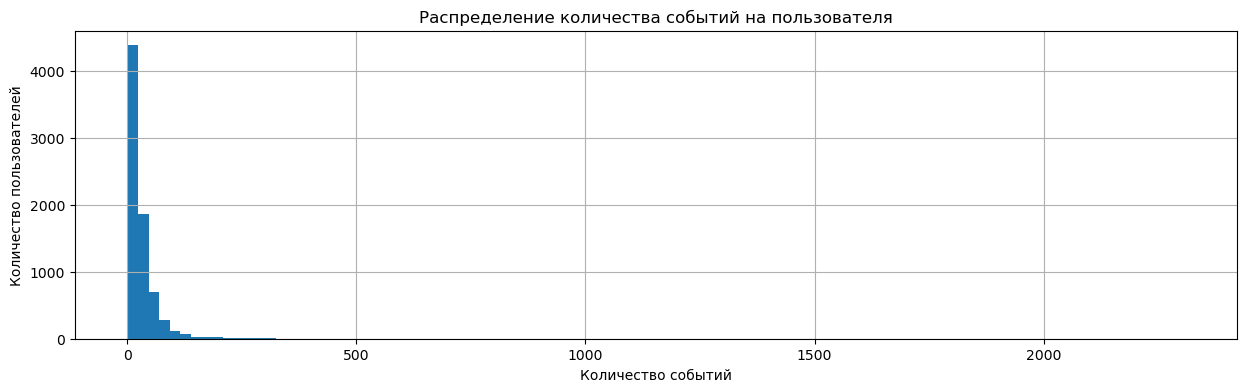

In [49]:
plt.figure(figsize=(15,4))
plt.hist(events_per_user, bins=100) 
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.grid()
plt.title('Распределение количества событий на пользователя');

Больше всего пользователей совершили 1 до 50 событий. Перестроим гистограмму с ограничем количества событий на пользователя до 100.

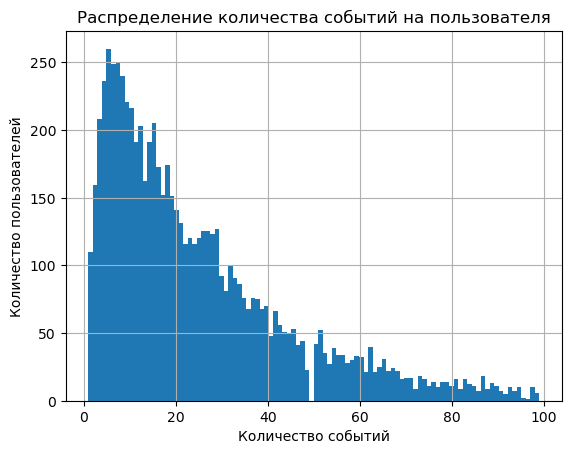

In [50]:
plt.hist(events_per_user.query('event_count<100'), bins=100)
plt.title('Распределение количества событий на пользователя')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.grid();

Больше всего пользователей совершили 5 действий в приложении. С ростом количества действий уменьшается и количество пользователей их совершивших.

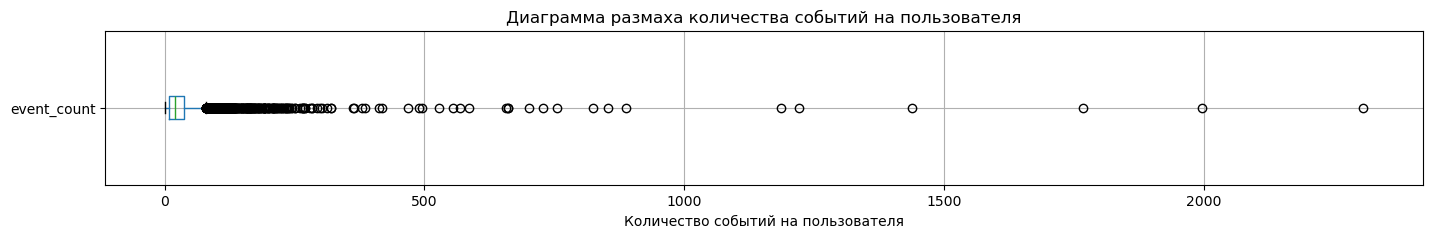

In [51]:
fig, ax = plt.subplots(figsize = (17,2))
ax = events_per_user[['event_count']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха количества событий на пользователя')

plt.xlabel("Количество событий на пользователя");


<a id='step_4_4'></a>
### Определение временных границ эксперимента

In [52]:
print('Старт эксперимента:', logs_exp['date'].min())
print('Конец эксперимента:', logs_exp['date'].max())

Старт эксперимента: 2019-07-25
Конец эксперимента: 2019-08-07


Построим столбчатую диаграммму которая отобразит количество событий в зависимости от времени в разрезе групп:

In [53]:
group_246 = logs_exp.query('exp_id==246')
group_246 = group_246.groupby('date').agg({'event_name':'count'}).reset_index()
group_246.columns = ['date','246']
group_246 = group_246.set_index('date')

group_247 = logs_exp.query('exp_id==247')
group_247 = group_247.groupby('date').agg({'event_name':'count'}).reset_index()
group_247.columns = ['date','247']
group_247 = group_247.set_index('date')

group_248 = logs_exp.query('exp_id==248')
group_248 = group_248.groupby('date').agg({'event_name':'count'}).reset_index()
group_248.columns = ['date','248']
group_248 = group_248.set_index('date')

bar_plot_date = pd.concat([
    group_246,
    group_247,
    group_248
], axis=1)

bar_plot_date.reset_index()

,date,246,247,248
0,2019-07-25,4,1,4
1,2019-07-26,14,8,9
2,2019-07-27,24,23,8
3,2019-07-28,33,36,36
4,2019-07-29,55,58,71
5,2019-07-30,129,138,145
6,2019-07-31,620,664,746
7,2019-08-01,11561,12306,12274
8,2019-08-02,10946,10990,13618
9,2019-08-03,10575,11024,11683


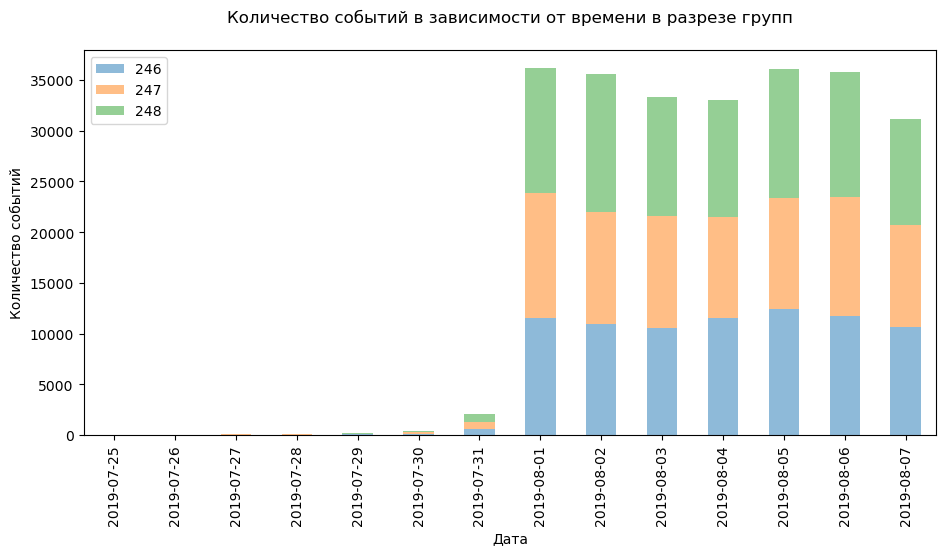

In [54]:
bar_plot_date.plot.bar(stacked=True, alpha=0.5, figsize=(11,5))
plt. ylabel("Количество событий")
plt.xlabel("Дата")
plt.title("Количество событий в зависимости от времени в разрезе групп", pad='20.0');

На графике хорошо видно, как мало зафиксировано событий в период с 25 по 31 июля 2019 года. **Будем считать что данные полные в период с 1 по 7 августа**, остальное отфильтруем.

Определим, много ли событий и пользователей было утрачено после фильтрации:

In [55]:
drop_date = logs_exp.query('date_time<"2019-08-01"')
print('Отфильтровано событий:', drop_date.shape[0])
print('Доля отфильтрованных событий от общего объёма данных:', round(drop_date.shape[0]/logs_exp.shape[0]*100,2), "%")

Отфильтровано событий: 2826
Доля отфильтрованных событий от общего объёма данных: 1.16 %


In [56]:
uq_users_before = logs_exp['device_id_hash'].nunique()
logs_exp = logs_exp.query('date_time>="2019-08-01"')
uq_users_after = logs_exp['device_id_hash'].nunique()
print('Отфильтровано пользователей:', uq_users_before - uq_users_after)
print('Доля отфильтрованных событий от общего объёма данных:', round((uq_users_before - uq_users_after)/uq_users_before*100,2), "%")

Отфильтровано пользователей: 17
Доля отфильтрованных событий от общего объёма данных: 0.23 %


Проверим, что в отфильтрованной выборке присутствуют пользователи  из трёх эксперементальных групп.

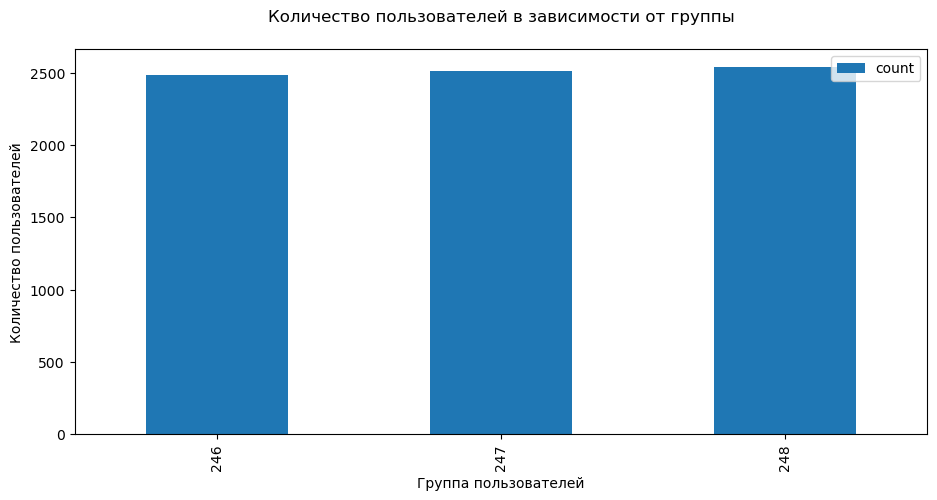

In [57]:
filtered_users = logs_exp.groupby('exp_id').agg({'device_id_hash':'nunique'}).reset_index()
filtered_users.columns = ['exp_id','count']

filtered_users.plot(x = 'exp_id', y='count',kind = 'bar', figsize=(11,5))
plt.ylabel("Количество пользователей")
plt.xlabel("Группа пользователей")
plt.title("Количество пользователей в зависимости от группы", pad='20.0');

In [58]:
filtered_users.set_index('exp_id')

,count
exp_id,
246,2484
247,2513
248,2537


**Вывод**: В ходе проверки данных выяснили, что на исследование были предоставлены данные с 25.07.2019 по 07.08.2019. В логе находились записи о 243&nbsp;713 событиях. Количество уникальных пользователей: 7551. Среднее количество событий на пользователя &mdash; 32.28. После визуальзации распределяния событий по времени, определили что наиболее полные данные представлены за период с 1 по 7 августа, остальные данные отфильтруем. После фильтрации было утрачено 2826 записей о событиях с 25 июля по 31 июля и данные (~1% от общего объёма), и о 17 уникальных пользователях (<1% от общего объема). В отфильтрованном датафрейме присутствуют пользователи из всех трёх уникальных групп.

<a id='step_5'></a>
## Изучение воронки событий

<a id='step_5_1'></a>
### Частота встречаемости событий в логах

In [59]:
filtered_events = logs_exp.groupby('event_name')['event_name'].count()
filtered_events.sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Наиболее популярным событием является `MainScreenAppear` &mdash; появление главного экрана (117 328 событий), на втором месте `OffersScreenAppear` &mdash; появление экрана предложения (46 333 события), на третьем месте `CartScreenAppear` &mdash; появление экрана корзины (42 203 события), на четвёртом месте `PaymentScreenSuccessful` &mdash; появление экрана успешной оплаты (33 918 события), и на последнем месте `Tutorial` &mdash; обучение (1005 событий).

<a id='step_5_2'></a>
### Определение количества пользователей совершивших каждое из событий

In [60]:
filtered_events = logs_exp.pivot_table(index = 'event_name', values = 'device_id_hash', aggfunc='nunique').sort_values(by = 'device_id_hash', ascending = False)
filtered_events.columns = ['device_count']
filtered_events['share'] = round(filtered_events['device_count']/logs_exp['device_id_hash'].nunique()*100,2)
filtered_events

,device_count,share
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


Около 1.5% пользователей миновали главный экран. Причины могут быть следующими:
1. Пользователь попал на главный экран 31.07 поздней ночью, а заказ завершил только 01.08. Так как выше были отфильтрованы логи с 25.07 по 31.07 были утеряны записи о входе в воронку событий.
2. Возможно приложение рассылает рекламные push-сообщения/письма/SMS с прямой ссылкой на экран предложений. Пользователь делает заказ минуя главный экран.

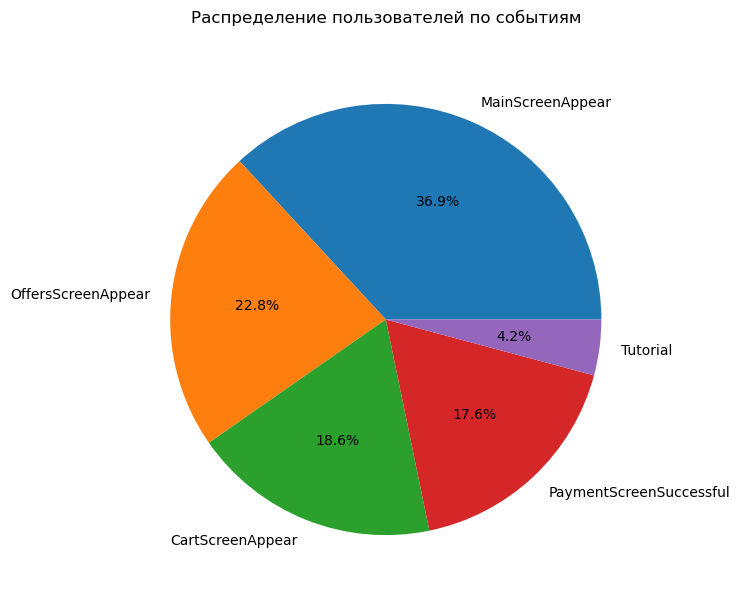

In [61]:
filtered_events.plot( y='share', kind = 'pie', autopct='%1.1f%%', figsize=(7, 7), legend = None)
plt.ylabel("")
plt.title("Распределение пользователей по событиям", pad='20.0');

Больше всего пользователей увидели экран главного приложения (событие `MainScreenAppear`) &mdash; 98.47%, экран предложений (`OffersScreenAppear`) увидели 60.96% пользователей, корзину (`CartScreenAppear`) &mdash; 49.56%, а экран успешной оплаты (`PaymentScreenSuccessful`) &mdash; 46.97%. Обучение (`Tutorial`) прошли только 11.15% пользователей.

<a id='step_5_3'></a>
### Вид воронки событий

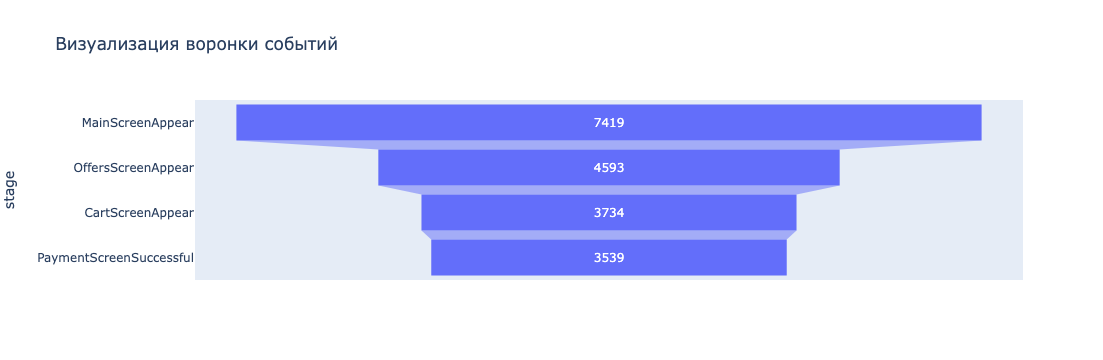

In [62]:
filtered_events = filtered_events.reset_index()
filtered_events = filtered_events.query('event_name!="Tutorial"')
data = dict(
    number = filtered_events['device_count'],
    stage = filtered_events['event_name']) 
fig = px.funnel(data, x='number', y='stage', title='Визуализация воронки событий')
fig.show()


Согласно диаграмме воронка событий имеет следующий вид:  
`MainScreenAppear` → `OffersScreenAppear` → `CartScreenAppar` → `PaymentSuccessfull`  
Сначала пользователь попадает на главный экран приложения. Далее переходит на экран предложений (товаров), после чего перемещается в корзину и оплачивает заказ. Обучение `Tutorial` не входит в воронку &mdash; это событие опционально, сделать заказ можно не проходя обучение.

<a id='step_5_4'></a>
### Расчёт доли пользователей, переходящих на следующий шаг воронки

In [63]:
filtered_events['conversion_events'] =  round((filtered_events['device_count'].pct_change() + 1)*100,2)
filtered_events

,event_name,device_count,share,conversion_events
0,MainScreenAppear,7419,98.47,NaN
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


Больше всего теряется пользователей при переходе от первого шага воронки (появление Главного экрана) ко второму (Появление экрана с предложением товара) (теряется 38% пользователей). 

In [64]:
total_conversion = round(filtered_events['device_count'][3]/filtered_events['device_count'][0],2)*100
print('Доля пользователей, дошедших от первого события до оплаты:',total_conversion,'%')


Доля пользователей, дошедших от первого события до оплаты: 48.0 %


**Вывод**: наиболее более популярным событием является `MainScreenAppear` &mdash; оно же открывает воронку событий, которая имеет следующий вид: `MainScreenAppear` → `OffersScreenAppear` → `CartScreenAppar` → `PaymentSuccessfull`   
По расчётам доли пользователей, перешедших на следующий шаг воронки, больше всего пользователей теряется при переходе от первого шага воронки (появление Главного экрана) ко второму (появление экрана с предложением товара) &mdash; 38%: возможно есть какая-то проблема на главном экране, которая мешает перейти на следующий шаг: например не все ссылки/кнопки активны, или другая ошибка, которая усложняет процесс оформелния заказа или отпугивает пользователя. Самые малые потери на этапе перехода от экрана корзины к оплате &mdash; 95% пользователей переходят от шага 3 к шагу 4.

<a id='step_6'></a>
## Изучение результатов эксперимента

<a id='step_6_1'></a>
### Определение количества пользователей в каждой экспериментальной группе

In [65]:
filtered_users = logs_exp.groupby('exp_id').agg({'device_id_hash':'nunique'}).reset_index()
filtered_users.columns = ['exp_id','count']

filtered_users = filtered_users.set_index('exp_id')
filtered_users

,count
exp_id,
246,2484
247,2513
248,2537


<a id='step_6_2'></a>
### Проверка наличия статистической значимости между пользователями групп 246 и 247 (A/A-тест)

Проверим что выборки отвечают критериям успешного A/A-теста:  
1. Количество пользователей в различных группах различается не более, чем на 1%; 

In [66]:
count_diff = 1 - logs_exp.query('exp_id==246')['device_id_hash'].nunique()/logs_exp.query('exp_id==247')['device_id_hash'].nunique()
print('Разница между количеством пользователей составляет:', round(count_diff,2)*100, '%')

Разница между количеством пользователей составляет: 1.0 %


2. Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;

In [67]:
display(logs_exp.query('exp_id==246').head(5))
logs_exp.query('exp_id==247').head(5)

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2834,OffersScreenAppear,3737462046622621720,1564618226,246,2019-08-01 00:10:26,2019-08-01


,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
2833,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01
2838,MainScreenAppear,4899590676214355127,1564618288,247,2019-08-01 00:11:28,2019-08-01
2839,OffersScreenAppear,4899590676214355127,1564618290,247,2019-08-01 00:11:30,2019-08-01
2843,OffersScreenAppear,4899590676214355127,1564618356,247,2019-08-01 00:12:36,2019-08-01


3. Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

In [68]:
logs_exp.groupby('device_id_hash').agg({'exp_id':'nunique'}).sort_values('exp_id', ascending=False)

,exp_id
device_id_hash,
6888746892508752,1
6204944347213293942,1
6215559225876063378,1
6215162890135937308,1
6213626876710715478,1
...,...
3171454373076660766,1
3170212200647575044,1
3167974726645136146,1


Каждый пользователь принадлежит только одной группе A/A/B-теста.

4. Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;  
Сформулируем нулевую и альтернативную гипотезы:  
$H_0$: Доли пользователей на каждом из этапов воронки в выборках 246 и 247 равны.  
$H_1$: Доли пользователей на каждом из этапов воронки в выборках 246 и 247 различны.  

Проверим гипотезу о равенстве долей с помощью Z-теста.

In [69]:
filtered_events = logs_exp.query('event_name!="Tutorial"')
filtered_events = filtered_events.pivot_table(index = 'exp_id', columns='event_name', values = 'device_id_hash', aggfunc='nunique').reset_index()
filtered_events['total'] = [filtered_users.loc[246,"count"], filtered_users.loc[247,"count"], filtered_users.loc[248,"count"]]
filtered_events = filtered_events.set_index('exp_id')   
filtered_events

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,total
exp_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


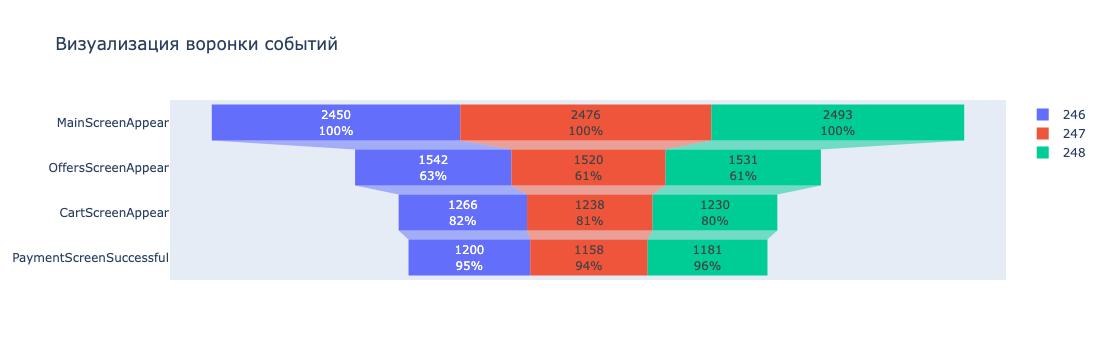

In [70]:
funnel_plot = logs_exp.query('event_name!="Tutorial"')
funnel_plot = funnel_plot.pivot_table(index = ['exp_id','event_name'], values = 'device_id_hash', aggfunc='nunique').reset_index()
funnel_plot = funnel_plot.sort_values(by='device_id_hash', ascending=False)

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    y = funnel_plot.query('exp_id==246')['event_name'],
    x = funnel_plot.query('exp_id==246')['device_id_hash'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = funnel_plot.query('exp_id==247')['event_name'],
    x = funnel_plot.query('exp_id==247')['device_id_hash'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = funnel_plot.query('exp_id==248')['event_name'],
    x = funnel_plot.query('exp_id==248')['device_id_hash'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.update_layout(title="Визуализация воронки событий")
fig.show()

Для удобства определим специальную функцию, которая будет рассчитывать Z-критерий для двух групп. На вход фунции так же подается уровень статистической значимости $\alpha$ который в теле корректируется с помощью поправки Бонферрони:

In [71]:
def z_test(group_1, group_2, alpha):
    events_name = ['CartScreenAppear','MainScreenAppear','OffersScreenAppear', 'PaymentScreenSuccessful']
    
    #внесение поправки Бонферрони 
    alpha/=16
    #для каждого события каждой группы рассчитаем Z-value и p-value
    for event in events_name:
        p1 = group_1[event]/group_1['total']
        p2 = group_2[event]/group_2['total']
        p_combined = (group_1[event] + group_2[event])/(group_1['total'] + group_2['total'])
        difference = p1 - p2 
        
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_1['total'] + 1/group_2['total']))

        distr = st.norm(0, 1)  
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('Событие:', event)
        print('p-value:', p_value)
        
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными\n') 


Вызовем функцию расчёта Z-критерия для двух групп: 246 и 247. Веричину $\alpha$ примем равной 0.01 (вероятность отклонить гипотизу $H_0$, когда она на самом деле верна).

In [72]:
z_test(filtered_events.loc[246],filtered_events.loc[247], 0.01)

Событие: CartScreenAppear
p-value: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p-value: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



В результате рассчетов выснили, что статистической разницы между A/A-группами нет. Можно сделать вывод, что разделение на группы работает корректно.

<a id='step_6_3'></a>
### Анализ результатов A/B-теста

Сравним каждую контрольную группу с результатами группы B. Здесь уровень статистической значимости примем равнм 0.05:

In [73]:
z_test(filtered_events.loc[246],filtered_events.loc[248], 0.05)

Событие: CartScreenAppear
p-value: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p-value: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [74]:
z_test(filtered_events.loc[247],filtered_events.loc[248], 0.05)

Событие: CartScreenAppear
p-value: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p-value: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Сравним результаты с объединенной контрольной группой (добавим строку 246247, которая будет содержать объединенные результаты контрольной выборки):

In [75]:
filtered_events.loc[246247] = filtered_events.loc[247] + filtered_events.loc[246]
filtered_events

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,total
exp_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
246247,2504,4926,3062,2358,4997


In [76]:
z_test(filtered_events.loc[246247],filtered_events.loc[248], 0.05)

Событие: CartScreenAppear
p-value: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
p-value: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод**:
1. В 246 группе 2484 пользователей, в 247 &mdash; 2513, в 248 &mdash; 2537.  
2. Контрольные группы 246 и 247 отвечают критериям A/A-теста, по результам статистического теста различий между выборками не выявлено.  
3. Так же при проведении статистических тестов контрольных групп и эксперементальных (попарно и объединенной) не было выявлено различий между выборками.

<a id='step_6_4'></a>
### Выбор уровня статистической значимости


Было проведено 4 проверки статистических гипотез, проверка гипотезы о равенстве долей двух контрольных групп (A/A-тест), поочередная проверка группы с измененным шрифтом с каждой из контрольной групп и с объединённой выборкой. 

Первая проверка была проведена с уровнем значимости 0.01, т.к. по условию А/А теста различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости.

Остальные проверки были выполнены с уровнем статистической значимости $\alpha$ = 0.05. Выбор уровня статистической значимости зависит от нескольких факторов: 
1. Оценка потенциальных рисков, связанных с ошибками первого и второго рода. Каковы последствия ошибочного отклонения нулевой гипотезы? Что будет, если реального различия не обнаружится? 
2. Какой эффект ожидается от внедряемого изменения? Если рост метрик будет ощутимым, можно позволить себе выбрать более низкий уровень значимости, тем самым уменьшая вероятность ошибки первого рода, не рискуя при этом пропустить значимый эффект из-за недостаточной мощности теста. 

Так как исследуемое изменение &mdash; это сравнение двух разных шрифтов приложений, сложно ожидать от него серьезного прорыва в росте конверсии. При этом не хотелось бы опускать уровень значимости до 0.01 &mdash; следует помнить, что выбор слишком малого уровня значимости приведёт к увеличению вероятности ошибки второго рода при принятии статистического решения.

<a id='step_7'></a>
##  Выводы

<p>На основе результатов обработки данных, содержащих лог с информацией о действиях пользователей и событиях можем сделать следующие выводы:</p>
<ol>
    <li>Исходные данные потребовали предобработки: были обнаружены явные дубликаты (удалены). Названия столбцов были приведены к змеиному регистру. Так же были добавлены дополнительные столбцы с датой и временем события на основе значений столбца <code>event_timestamp</code> который содержал количество секунд, прошедших с 01.01.1970.</li>
    <li>В ходе изучения и проверки данных определили границы эксперимента: с 01.08.2019 по 07.08.2019. Данные, не вошедшие в этот диапазон, были убраны из датафрейма. В связи с этим потеряли 1% событий из общего числа и &#60;1% процента пользователей. В отфильтрованном датафрейме присутствуют пользователи из всех трёх уникальных групп.</li>
    <li>Определен вид воронки событий: <code>MainScreenAppear</code> → <code>OffersScreenAppear</code> → <code>CartScreenAppar</code> → <code>PaymentSuccessfull</code>  
Сначала пользователь попадает на главный экран приложения. Далее переходит на экран предложений (товаров), после чего перемещается в корзину и оплачивает заказ. Обучение `Tutorial` не входит в воронку &mdash; это событие опционально, сделать заказ можно не проходя обучение. Больше всего пользователей теряется при переходе с шага 1 на шаг 2 &mdash; 38%. 48% пользователей проходят путь от главного экрана до успешной оплаты заказа.</li>
    <li>Выборка пользоватей групп 246 и 247 отвечает критериям A/A-тестирования. Проверка показала, что статистически важного различия между контрольными группами нет.</li>
    <li>По результатам статистических тестов контрольных групп 246 и 247 и эксперементальной 248 (попарно и объединенной) не было выявлено различий между выборками. <b>Новые шрифты, которые показывали пользователям группы 248 никак не повлияли на поведение пользователей внутри приложения</b>. Тест можно завершить.</li>
</ol>    